Link to the Github Repo:
https://github.com/shikha-16/Human-Consensus-Oriented-Image-Captioning

In [1]:
!pip install pytorch-pretrained-bert

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
import random
import re
from scipy import ndimage
from torch.autograd import Variable
from PIL import Image
import numpy as np

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertModel
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 KB 874.5 kB/s eta 0:00:00a 0:00:01


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
scaler = transforms.Resize([224, 224])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

feature_extraction = torchvision.models.resnet18(pretrained=True).to(device)
feature_extraction = nn.Sequential(*list(feature_extraction.children())[:-2]).to(device)

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_WE = BertModel.from_pretrained('bert-base-uncased').to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

100%|██████████| 407873900/407873900 [00:11<00:00, 35759188.87B/s]


In [4]:
for param in feature_extraction.parameters():
    param.requires_grad_(False)
feature_extraction.eval()

def img_load_feat(img_loc,img_name):
    img_loc += str(img_name) + '.jpg'
    img = Image.open(img_loc)
    t_img = normalize(to_tensor(scaler(img)))
    t_img = t_img.to(device)
    t_img = torch.unsqueeze(t_img, 0)
    feature = feature_extraction(t_img)
    return feature

In [5]:
img_loc = '../input/flickr8k/Images/'
img_features = dict()
for img_id_jpg in os.listdir(img_loc):
    img_id = img_id_jpg.split('.')[0]
    img_features[img_id] = img_load_feat(img_loc, img_id)
    img_features[img_id].requires_grad_()

In [6]:
def get_cider(captions):

    cider = dict()
    tfidfVectorizers=[]
    for i in range(4):
        tf_idf_vect = TfidfVectorizer(ngram_range = (i+1,i+1))
        tfidfVectorizers.append(tf_idf_vect)
    for key in captions:
        corpus = captions[key]
        cider[key] = []
        
        tfidf_matrix = tfidfVectorizers[0].fit_transform(corpus)        
        tfidf_mat = tfidfVectorizers[0].fit_transform(corpus)
        mean_cider=0
        for i in range(len(corpus)):
            mean_cider=0
            for n in range(4):
                tfidf_mat = tfidfVectorizers[0].fit_transform(corpus)
                tfidf_mat = tfidf_mat.todense().tolist()
                r = tfidf_mat[i] 
                r_norm = np.linalg.norm(np.array(r))
                sum = 0
                for j in range(len(corpus)):
                    if i != j:
                        vec_norm = np.linalg.norm(np.array(tfidf_mat[j]))
                        sum += (np.dot(r,tfidf_mat[j])/(np.sqrt(r_norm*vec_norm)))
                mean_cider += (sum/(len(corpus)-1))
            mean_cider /= 4.0
            cider[key].append(mean_cider)
            
    return cider

In [7]:
file = open('../input/flickr8k/captions.txt', 'r')
ip_desc = file.read()
file.close()

img_cap = dict()
data = list()
max_len = 35
index = 1
my_vocab = dict()
my_rev_vocab = dict()

my_vocab["[PAD]"] = 0
my_rev_vocab[0] = "[PAD]"

for line in ip_desc.split('\n')[1:-1]:
    if '"' in line:
        ip = re.split(r',(?=")',line)
    else:
        ip = line.split(',')
    
    # image name
    img_id = ip[0].split('.')[0]
    
    # cleaning desc
    clean_desc = ''
    for ch in ip[1]:
        if ('A'<=ch and ch<='Z') or ('a'<=ch and ch<='z') or ch==' ':
            clean_desc += ch
    clean_desc = "[CLS] " + clean_desc.rstrip().lower() + " [SEP]"
    
    # truncating sentences with len > max_len
    if len(clean_desc) > max_len:
        clean_desc = clean_desc[:max_len]
    
    # mapping each img_id to a list of 5 captions
    if img_id not in img_cap:
        img_cap[img_id] = list()
    img_cap[img_id].append(clean_desc)

In [8]:
all_ciders = get_cider(img_cap)

In [9]:
for img_id in img_cap:
    for cap_num in range(len(img_cap[img_id])):
        clean_desc = img_cap[img_id][cap_num]
        # tokenization of clean desc
        tok_desc = clean_desc.split()
        # tok_desc = tokenizer.tokenize(clean_desc)    

        # building vocab
        tok_desc_ind = list()
        for tok in tok_desc:
            if tok not in my_vocab:
                my_vocab[tok] = index
                my_rev_vocab[index] = tok
                index += 1
            tok_desc_ind.append(my_vocab[tok])

        # data
        for i in range(1,len(tok_desc_ind)-1):
            data.append([[img_id,tok_desc_ind[:i]],tok_desc_ind[i],all_ciders[img_id][cap_num]])

        tok_desc_ind += [0]*(max_len-len(tok_desc))

In [10]:
train_data = data[:(80*len(data))//100]
test_data = data[(80*len(data))//100:]
# train_data, test_data = torch.utils.data.random_split(img_ids, [int(0.8*len(img_ids)),len(img_ids)-int(0.8*len(img_ids))])

print(index, len(img_features.keys()), len(train_data))

7839 8091 172885


In [11]:
class ConsensusLoss(torch.nn.Module):
    
    def _init_(self):
        super(ConsensusLoss,self)._init_()
        
    def forward(self, outputs, targets, cider):
        
        den=0
        op = torch.exp(outputs[0])
        den = torch.sum(op)
        op = torch.div(op, den)
        
        ce = -1*torch.log(op[targets[0]])
        cl = (ce*cider)
        
        return cl

In [12]:
class SelfAttention(nn.Module):
    
    def __init__(self):
        super(SelfAttention,self).__init__()
        
        in_dim = 512
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1)
        
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        
        m_batchsize,C,width,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out, attention

In [13]:
class BERT_WE(nn.Module):
    
    def __init__(self):
        super(BERT_WE,self).__init__()
        
    def forward(desc):
        att_mask = torch.IntTensor([[1]*len(desc) + [0]*(max_len-len(desc))]).to(device)
        pad_desc = (desc + [0]*(max_len-len(desc)))
        t_pad_desc = torch.IntTensor([pad_desc]).to(device)
        bert_WE.eval()
        embedding = (bert_WE(t_pad_desc, attention_mask = att_mask, output_all_encoded_layers = False))[0][0][-1]
        return embedding

In [14]:
class Caption_Generation(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.attention = SelfAttention()
        self.flatten = nn.Flatten()
        self.img_proc = nn.Sequential(nn.Linear(7*7*512,4096), nn.Dropout(0.2), nn.ReLU(),
                                    nn.Linear(4096,1024), nn.Dropout(0.2), nn.ReLU()
                                   )
        
        self.embed = BERT_WE()
        self.lstm = nn.LSTM(1792,1024)
        
        self.cap_proc = nn.Sequential(
                                    nn.Linear(1024,512), nn.Dropout(0.2), nn.ReLU(),
                                    nn.Linear(512,256), nn.Dropout(0.2), nn.ReLU(),
                                    nn.Linear(256,index), nn.Dropout(0.2), nn.ReLU()
                                   )
                
        self.cap_gen = nn.Sequential(
            nn.Linear(256,128), nn.ReLU(),
            nn.Linear(128,index), nn.ReLU()
        )
    
    def forward(self, feat, desc):
        
        context, att_wts = self.attention(feat)
        ip1 = self.flatten(context)
        ip1 = self.img_proc(torch.tensor(ip1))
        
        att_mask = torch.IntTensor([[1]*len(desc) + [0]*(max_len-len(desc))]).to(device)
        pad_desc = (desc + [0]*(max_len-len(desc)))
        t_pad_desc = torch.IntTensor([pad_desc]).to(device)
        bert_WE.eval()
        ip2 = (bert_WE(t_pad_desc, attention_mask = att_mask, output_all_encoded_layers = False))[0][0][-1]
        ip2 = torch.tensor(torch.unsqueeze(ip2,0)).to(device)
        
        ip = torch.cat([ip1, ip2], 1)
        ip = self.lstm(ip)[0]
        # print(type(ip))
        out = self.cap_proc(ip)
        
        # ip = torch.unsqueeze(torch.cat((ip1[0],ip2[0]),0),0)
        # out = self.cap_gen(ip)
        
        return out

In [15]:
def train(train_data, epochs, model, optim, loss_f):
    
    model = model.to(device)
    model.train()
    loss_vals = list()
    
    for epoch in range(epochs):
        train_loss = 0.0
        idx = 0
        for ip,op,score in train_data:
            if ip[0] not in img_features:
                continue
            optim.zero_grad()
            
            output = model(img_features[ip[0]],ip[1]).to(device)
            t_op = torch.LongTensor([op]).to(device)
            loss = loss_f(output,t_op,score)
            
            if idx%10000 == 0:
                print("idx: ", idx)
                print("img_id: ", ip[0])
                img = Image.open(img_loc+ip[0]+'.jpg')
                imgplot = plt.imshow(img)
                plt.show()
                
                print("ip:", end = ' ')
                for word in ip[1]:
                    print(my_rev_vocab[word], end = ' ')
                print()
                word = int(torch.max(output[-1].view(1,-1), 1)[1])
                word = my_rev_vocab[word]
                print("actual op: ", word)
                print("target op:", my_rev_vocab[op])
                print("loss: ", loss.item())
                print("\n---------------------------------------\n")
            idx += 1
            
            train_loss += loss.item()
            loss_vals.append(train_loss)
            loss.backward()
            optim.step()
        
        train_loss /= len(train_data)
        print('Epoch: ', epoch, 'Avg Train loss: ', float(train_loss))
        
    plt.plot(np.array(loss_vals), 'r')
        

def test(img_loc, test_data, model, loss_f):
    model.eval()
    test_loss = 0.0
    
    for ip,op,score in train_data:
        if ip[0] not in img_features:
            continue

        output = model(img_features[ip[0]],ip[1])
        t_op = torch.LongTensor([op]).to(device)
        loss = loss_f(output,t_op,score)
        test_loss += loss.item()
        
        # printing img, given input prefix sentence, predicted next word, expected next word
        print(ip[0], loss.item())
        img = Image.open(img_loc+ip[0]+'.jpg')
        imgplot = plt.imshow(img)
        plt.show()
        print("ip:", end = ' ')
        for word in ip[1]:
            print(my_rev_vocab[word], end = ' ')
        print()
        word = int(torch.max(output[-1].view(1,-1), 1)[1])
        word = my_rev_vocab[word]
        print("actual op: ", word)
        print("target op:", my_rev_vocab[op])
        
    test_loss /= len(test_data)
    print('Epoch: ', epoch, 'Avg Test loss: ', float(test_loss))

Total Parameters:  122545599
Trainable Parameters:  122545599



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


idx:  0
img_id:  1000268201_693b08cb0e


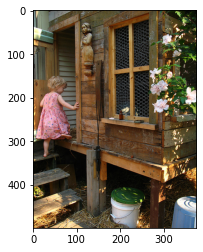

ip: [CLS] 
actual op:  pitcher
target op: a
loss:  1.6270661354064941

---------------------------------------

idx:  10000
img_id:  1387443857_602ab6f9bf


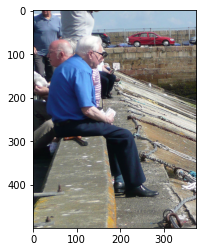

ip: [CLS] an old man is sitting on 
actual op:  a
target op: a
loss:  0.8054064512252808

---------------------------------------

idx:  20000
img_id:  181157221_e12410ef0b


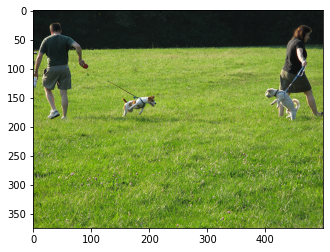

ip: [CLS] 
actual op:  a
target op: two
loss:  2.987103223800659

---------------------------------------

idx:  30000
img_id:  2158247955_484f0a1f11


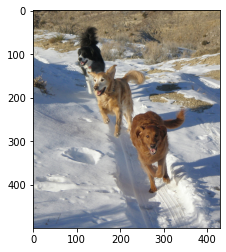

ip: [CLS] three dogs running on 
actual op:  a
target op: tire
loss:  2.311650276184082

---------------------------------------

idx:  40000
img_id:  230016181_0c52b95304


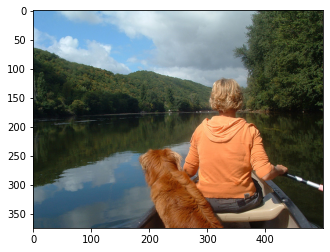

ip: [CLS] a 
actual op:  a
target op: woman
loss:  2.896486282348633

---------------------------------------

idx:  50000
img_id:  2426724282_237bca30b5


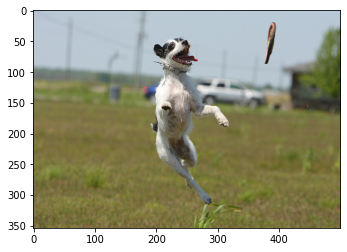

ip: [CLS] a 
actual op:  in
target op: small
loss:  1.4724376201629639

---------------------------------------

idx:  60000
img_id:  2544426580_317b1f1f73


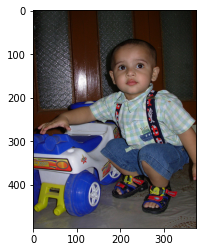

ip: [CLS] the baby in suspenders 
actual op:  a
target op: sits
loss:  1.9754854440689087

---------------------------------------

idx:  70000
img_id:  2666078276_f7b3056997


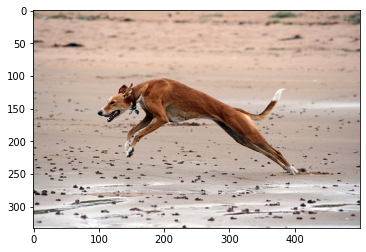

ip: [CLS] a dog leaps on the 
actual op:  a
target op: beach
loss:  1.822171688079834

---------------------------------------

idx:  80000
img_id:  2798651021_2566f2a47e


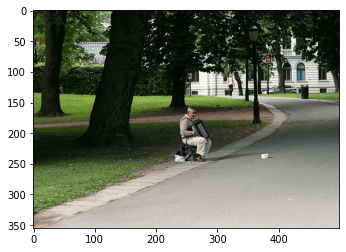

ip: [CLS] a 
actual op:  a
target op: man
loss:  1.8835548162460327

---------------------------------------

idx:  90000
img_id:  2907073768_08fd7bdf60


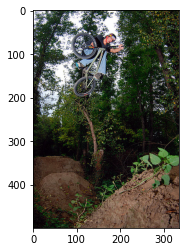

ip: [CLS] the bmx rider wearing 
actual op:  a
target op: a
loss:  0.10657048225402832

---------------------------------------

idx:  100000
img_id:  3019857541_3de3e24f54


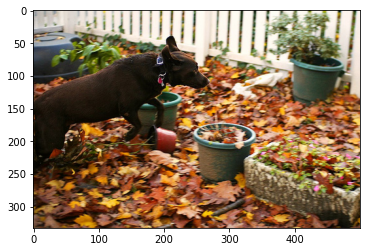

ip: [CLS] a dog knocking over 
actual op:  a
target op: potted
loss:  1.0002840757369995

---------------------------------------

idx:  110000
img_id:  3118425885_f0cc035032


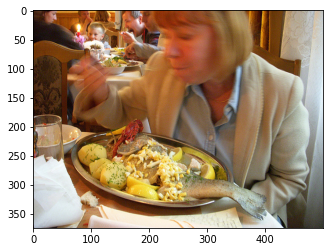

ip: [CLS] 
actual op:  a
target op: a
loss:  0.7145417928695679

---------------------------------------

idx:  120000
img_id:  3205336477_037d4b6bd9


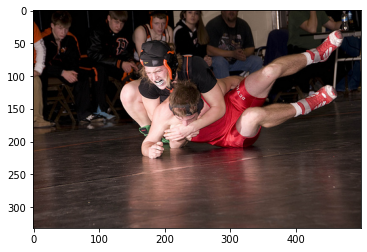

ip: [CLS] two 
actual op:  a
target op: men
loss:  3.384498357772827

---------------------------------------

idx:  130000
img_id:  3276475986_66cd9cc7e4


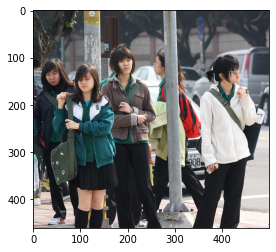

ip: [CLS] these 
actual op:  a
target op: girls
loss:  2.542855739593506

---------------------------------------



In [ ]:
caption_generation = Caption_Generation().to(device)

print("Total Parameters: ", sum(p.numel() for p in caption_generation.parameters()))
print("Trainable Parameters: ", sum(p.numel() for p in caption_generation.parameters() if p.requires_grad))
print()

optimizer = torch.optim.Adam(caption_generation.parameters(), lr = 5e-4)
loss = ConsensusLoss().to(device)
train(train_data, 1, caption_generation, optimizer, loss)

In [ ]:
test(img_loc, test_data[:10], caption_generation, loss)

Sample Test

In [ ]:
def generate_caption(img_feature, caption, model):
    model = model.to(device)
    model.eval()
    output = model(img_feature, caption).to(device)
    next_word = torch.max(output[-1].view(1,-1), 1)[1].to(device)
    if next_word == my_vocab["[SEP]"] or len(caption) == max_len-1:
        caption.append(my_vocab["[SEP]"])
        return caption
    caption.append(next_word)
    return generate_caption(img_feature, caption, model)

In [ ]:
# random.seed(5)
img_id = data[random.randint(0,len(data)-1)][0][0]
print(img_id)
img = Image.open(img_loc+img_id+'.jpg')
imgplot = plt.imshow(img)
plt.show()

caption = generate_caption(img_features[img_id], [my_vocab["[CLS]"]], caption_generation)
for word_seq in caption:
    print(my_rev_vocab[int(word_seq)], end = ' ')

References:
* https://www.ijcai.org/proceedings/2020/0092.pdf
* https://towardsdatascience.com/a-guide-to-image-captioning-e9fd5517f350
* https://arxiv.org/pdf/1411.4555.pdf
* https://www.analyticsvidhya.com/blog/2018/04/solving-an-image-captioning-task-using-deep-learning/
* https://towardsdatascience.com/3-types-of-contextualized-word-embeddings-from-bert-using-transfer-learning-81fcefe3fe6d
* https://arxiv.org/pdf/1502.03044.pdf


* https://medium.com/analytics-vidhya/image-captioning-with-attention-part-1-e8a5f783f6d3
* https://medium.com/analytics-vidhya/image-captioning-with-attention-part-2-f3616d5cf8d1


* https://discuss.pytorch.org/t/attention-in-image-classification/80147
* https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py#L8
* https://arxiv.org/pdf/1805.08318.pdf